Copyright 2023 Heather Tweedie

  Licensed under the Apache License, Version 2.0 (the "License");
  you may not use this file except in compliance with the License.
  You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

  Unless required by applicable law or agreed to in writing, software
  distributed under the License is distributed on an "AS IS" BASIS,
  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
  See the License for the specific language governing permissions and
  limitations under the License.

# Modelling the climate and the weather

### Heather Tweedie, March 2023

GHCN (Global Historical Climatology Network)-Daily is a database of daily climate summaries from land surface stations across the globe. This study aims to determine if the weather and climate at a location can be predicted using basic machine learning techniques. Two main research questions are proposed:
1. Can a model predict the weather at a location any better than assuming the weather tomorrow will be the same as the weather today?
2. How accurately can a model predict the climate of a location a year in advance?

This notebook will focus on the second of these questions.


Journal article describing GHCN-Daily:
Menne, M.J., I. Durre, R.S. Vose, B.E. Gleason, and T.G. Houston, 2012:  An overview of the Global Historical Climatology Network-Daily Database.  Journal of Atmospheric and Oceanic Technology, 29, 897-910, doi:10.1175/JTECH-D-11-00103.1.

Dataset used:
Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - Daily (GHCN-Daily), Version 3.12, NOAA National Climatic Data Center. http://doi.org/10.7289/V5D21VHZ

In [1]:
import json
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

2023-03-22 22:11:10.237515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 22:11:10.481802: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 22:11:10.544450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 22:11:10.544491: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Retrieve data

To filter the stations used, only stations with fewer than 100 missing data points were considered. The number of missing values is calculated in the script `get_station_counts.py` (took ~50 minutes to run on my laptop). These counts are stored in the file `stat_counts_tmax.json` in the json format for ease of future loading, as this script need only be run once for a given set of stations and data. The file is opened and read below, then all stations with 100 or fewer missing data points saved in a seperate list. 

In [2]:
# open json file containing the number of data gaps for the stations
f = open('data/stat_counts_tmax.json')
data = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [name for name, count in data.items() if count <= 100]
print(f"Number of stations found: {len(no_gaps_tmax)}")


Number of stations found: 103


Retrieve data for the given station and variable. An instance of the GHCND class is created, then the `readCountriesFile` and `readStationsFile` methods called on it. These methods extract information on the countries and stations available and stores these in fields as dictionaries. The list of station names is stored as a seperate list for future use.

The station to be investigated is set from the list of those with few missing date points. The required file name is constructed from the station name, which is then used to build the url required to fetch the data from the course-provided web directory of data files. The required data file is then copied from this remote directory to a local one (`/data`). The `processFile` method is then called on the GHCND class instance to extract the data from this file into a dictionary.

Data for the variable specified is extracted from this dictionary into an instance of the `Variable` class, with fields for the values and their corresponding dates.

In [3]:
# create instance of the GHCND class and extract information on countries and stations from their respective files
ghn = GHCND()
ghn.readCountriesFile()
ghn.readStationsFile()

# get list of station names
station_names = ghn.getStatKeyNames()

# set station to be investigated
station = no_gaps_tmax[0]
print(f"Station selected: {station}")

# get url for a specified station
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/stations_daily/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(f"Station details: {ghn.getStation(station)}")

# extract data for specified variable into an instance of the Variable class
t_max = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
dates = t_max.get_dates()
vals = t_max.get_vals()


Read 219 countries and codes
Read 991 stations from the GSN
Station selected: ASN00003003
Filename: ASN00003003.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/ASN00003003.dly
destination: data/stations_daily/ASN00003003.dly
Station details: ASN00003003 is BROOME AIRPORT, Australia at -17.9475 122.2353 7.4


## Prepare data for training

As this section is concerend with the climate at a given station rather than the weather, the monthly mean for the specified variable is found by calling the `get_monthly_means` method on the instance of the Variable class. To improve the performance and training stavility of the model, he date are then normalised by calling the `normalise` method, which subtracts the mean of the entire dataset then subtracts the maximum value for each data point. The first ten months of these mean values and normalised mean values are plotted.

Number of months of data: 975


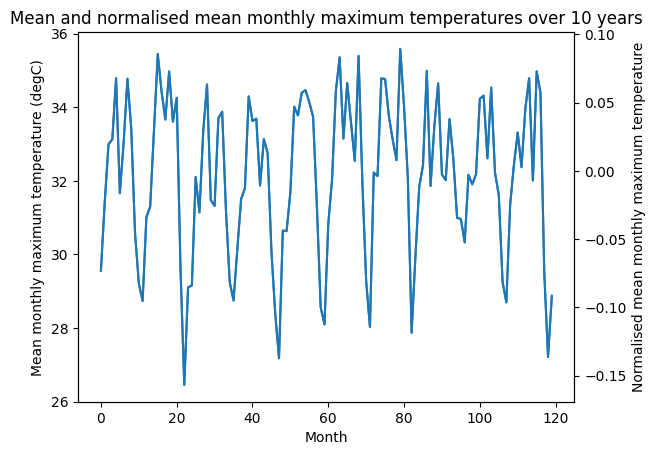

In [4]:
# get mean values for each month of data
means = np.array(t_max.get_monthly_means())
print(f"Number of months of data: {len(means)}")

# normalise means and store mean and max for later
means_normalised = t_max.normalise(means)
means_mean = np.mean(means)
means_max = np.max(means)

# plot means and normalised means
fig, ax = plt.subplots()
ax.plot(means[:12*10])
ax.set_xlabel("Month")
ax.set_ylabel("Mean monthly maximum temperature (degC)")
ax.set_title("Mean and normalised mean monthly maximum temperatures over 10 years")
ax2 = ax.twinx()
ax2.plot(means_normalised[:(12*10)])
ax2.set_ylabel("Normalised mean monthly maximum temperature")
plt.savefig('figures/climate_input_temps.svg', format = 'svg')


The data are divided into training, validating, and testing datasets. The training dataset must be the largest in order to provide sufficient material for the model to achieve a good performance. The testing dataset is smaller, but large enough that the model has sufficient input for predicting future sequences. The validation dataset is the smallest. A training:testing:validation ratio of 0.7:0.2:0.1 is used.

The offset describes how far into the future the model will predict. An offset of 12 is used here, meaning that the model will predict twelve months ahead. The window size dictates how much data the model is trained on in a single batch. If this is too small, the model will not perform well, however it must be smaller than the validation dataset minus the offset, otherwise it will be impossible to shape the dataset as necessary in later steps. It was found during testing that a window size of 80 worked well and gave a good performance.

The divided datasets are then split into a series of overlapping windows with length `WINDOW_SIZE`, and an associated value `OFFSET` points further ahead in the time series. These are the input windows and targets on which the model will be trained, validated and tested.

These windows are reshaped from (number of windows, window size) to (number of windows, window size, number of features), where 'number of features' is the number of variables being used in this model's training, in this case, one. 

In [5]:
OFFSET = 12

# calculate appropriate divisions of data
test_len = int(len(means_normalised) * 0.2)
train_len = int(len(means_normalised) * 0.7)
validate_len = int(len(means_normalised) * 0.1)

# if the validation dataset is too small, use a smaller window size
if validate_len < 80 + OFFSET + 1:
    WINDOW_SIZE = validate_len - OFFSET - 1
else:
    WINDOW_SIZE = 80

print(f"Number of months of training data: {train_len}")
print(f"Number of months of validation data: {validate_len}")
print(f"Number of months of testing data: {test_len}")

# divide data into training, validating and testing sets
means_test = means_normalised[:test_len]
means_train = means_normalised[test_len+1:test_len+train_len]
means_validate = means_normalised[test_len+train_len+1:]

# split data into input windows and targets
input_test, target_test = shapeArray(means_test, WINDOW_SIZE, OFFSET)
input_train, target_train = shapeArray(means_train, WINDOW_SIZE, OFFSET)
input_validate, target_validate = shapeArray(means_validate, WINDOW_SIZE, OFFSET)

# reshape the data into the correct format for input into the model
n_features = 1
input_train = input_train.reshape((input_train.shape[0], input_train.shape[1], n_features))
input_test = input_test.reshape((input_test.shape[0], input_test.shape[1], n_features))
input_validate = input_validate.reshape((input_validate.shape[0], input_validate.shape[1], n_features))


Number of months of training data: 682
Number of months of validation data: 97
Number of months of testing data: 195


## Train and predict

As this model is predicting only one variable, and to reduce run-time and over-fitting, it is less complex than the model used for predicting the weather. The relu activation function is used for the LSTM layer, as it was found during testing that using a linear activation function, the model was able to predict the sinusoidal pattern of the data, but could not predict sufficient amplitude of these waves.

In [6]:
model = keras.models.Sequential()
model.add(layers.LSTM(64, input_shape = (WINDOW_SIZE, 1), activation = 'relu', return_sequences = False))
model.add(layers.Dense(1, activation = "linear"))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.summary()

# train model and extract final loss
history = model.fit(input_train, target_train, epochs = 100, validation_data = (input_validate, target_validate))
cost = history.history['loss']
val_cost = history.history['val_loss']


2023-03-22 22:11:16.111995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 22:11:16.112067: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 22:11:16.112087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-03-22 22:11:16.115085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
19/19 [==============================] - 2s 35ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 2/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0026 - val_loss: 8.0494e-04
Epoch 4/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0025 - val_loss: 8.9283e-04
Epoch 5/100
19/19 [=====================

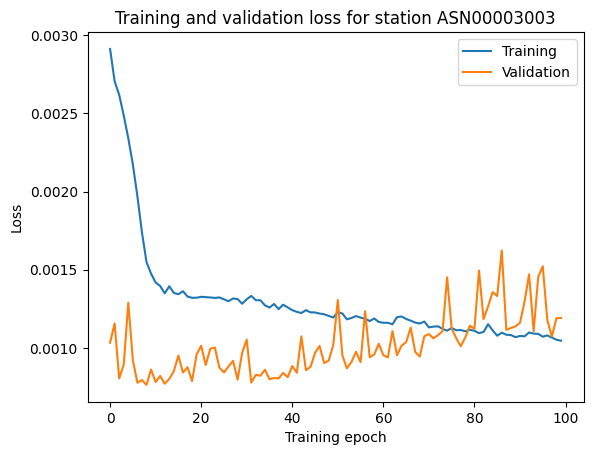

In [9]:
fig, ax = plt.subplots()
ax.plot(cost, label = "Training")
ax.plot(val_cost, label = "Validation")
ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")
ax.set_title(f"Training and validation loss for station {station}")
ax.legend()
plt.savefig('figures/climate_loss.svg', format = 'svg')


The model is now used to predict the climate a year in advance. The predicitons are plotted against the observed values.

4/4 [==============================] - 0s 18ms/step


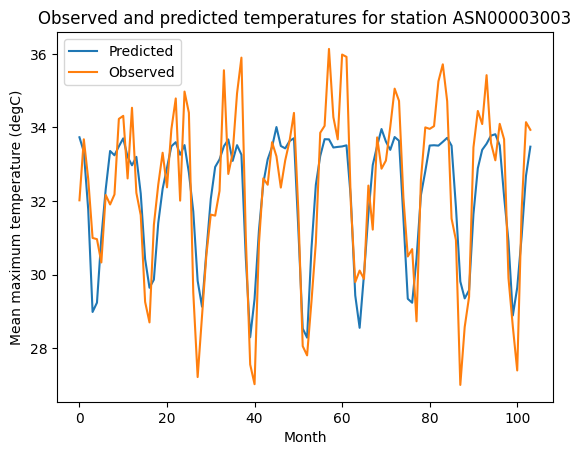

In [10]:
prediction = model.predict(input_test)
plot_pred = t_max.de_normalise(prediction, means_max, means_mean)
plot_target = t_max.de_normalise(target_test, means_max, means_mean)

fig, ax = plt.subplots()
ax.plot(plot_pred, label = "Predicted")
ax.plot(plot_target, label = "Observed")
ax.set_xlabel("Month")
ax.set_ylabel("Mean maximum temperature (degC)")
ax.set_title(f"Observed and predicted temperatures for station {station}")
ax.legend()
plt.savefig('figures/climate_prediction.svg', format = 'svg')


Like the weather prediction, the climate prediction model manages to predict the overall sinusoidal shape of the observations, however it is not able to accurately predict the extent of the peaks and troughs present in the recorded data. These appear to be difficult to predict as there is little or insifficient indication from the preceding observations of how high the temperature may reach in a given month.